# Modelling the data

In [1]:
# Load the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections
import seaborn as sns

df = pd.read_csv('../../data/df_main.csv')

In [2]:
df.loc[(df['year'] == 2004) & (df['from_code2'] == 'GB')].shape

(23, 29)

## XGBoost to predict if score given

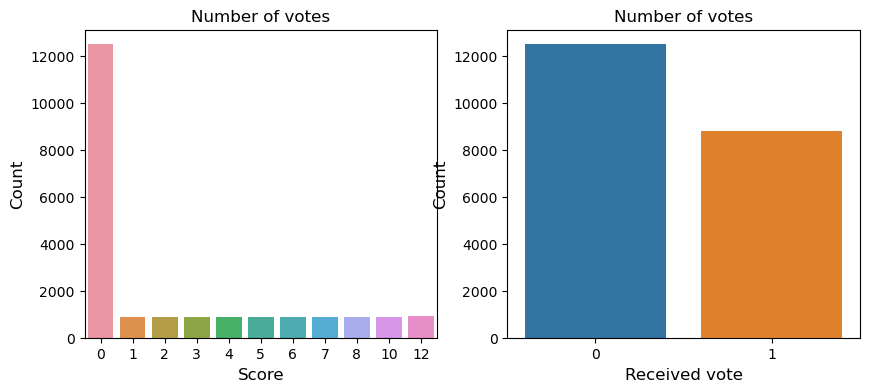

In [3]:
df['received_vote'] = df['points'].apply(lambda x: 1 if x > 0 else 0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


# Bar chart for vote occurrences
sns.countplot(x="points", data=df, ax=ax1)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Score', fontsize=12)
ax1.set_title('Number of votes', fontsize=12)

sns.countplot(x="received_vote", data=df, ax=ax2)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xlabel('Received vote', fontsize=12)
ax2.set_title('Number of votes', fontsize=12)

plt.show()

As you can see we have a lot of zeroes....this probably makes this problem appropriate for a hurdle model. Where we first decide if a score is given, and then if it is, we predict the score.

In [4]:
df.columns

Index(['year', 'Artist', 'from_country', 'to_country', 'points',
       'total_points', 'rank', 'from_code2', 'from_code3', 'to_code2',
       'to_code3', 'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language',
       'Contains_Voting_Language', 'gender', 'migration_v2p', 'population_p',
       'prop_emigrants_v2p', 'migration_p2v', 'population_v',
       'prop_emigrants_p2v', 'migration_pop_year', 'comps_without_win',
       'has_border', 'received_vote'],
      dtype='object')

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_83942/1787655178.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['has_border'] = df_xgboost['has_border'].fillna(0)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_83942/1787655178.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['prop_emigrants_v2p'] = df_xgboost['prop_emigrants_v2p'].apply(lambda x: np.log10(x+4e-8))
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_83942/1787655178.py:18: Setting

<AxesSubplot:>

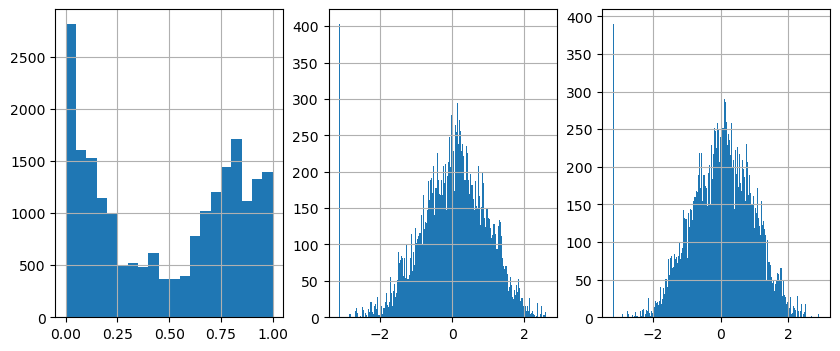

In [5]:
# scale some of the features

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


df_xgboost = df[['year', 'from_code2', 'points', 'to_code2',
        'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'Contains_Voting_Language', 'gender',
       'prop_emigrants_v2p',  'prop_emigrants_p2v', 'has_border',
       'comps_without_win', 'received_vote']]

df_xgboost['has_border'] = df_xgboost['has_border'].fillna(0)

# log10 scale the prop_emigrants column
df_xgboost['prop_emigrants_v2p'] = df_xgboost['prop_emigrants_v2p'].apply(lambda x: np.log10(x+4e-8))
df_xgboost['prop_emigrants_p2v'] = df_xgboost['prop_emigrants_p2v'].apply(lambda x: np.log10(x+4e-8))


# apply the standard scaler to prop_emigrants and comps_without_win
scaler = StandardScaler()
df_xgboost[['prop_emigrants_v2p']] = scaler.fit_transform(df_xgboost[['prop_emigrants_v2p']])
df_xgboost[['prop_emigrants_p2v']] = scaler.fit_transform(df_xgboost[['prop_emigrants_p2v']])

scaler = MinMaxScaler()
df_xgboost[['comps_without_win']] = scaler.fit_transform(df_xgboost[['comps_without_win']])


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

# histogram of the log scaled prop_emigrants column
df_xgboost['comps_without_win'].hist(bins=20, ax=ax1)
df_xgboost['prop_emigrants_v2p'].hist(bins=200, ax=ax2)
df_xgboost['prop_emigrants_p2v'].hist(bins=200, ax=ax3)

In [6]:

from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def basic_xgboost(df_input, seed, test_size, predictor_column='received_vote'):
    X = df_input[['from_code2', 'to_code2', 'points',
        'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'Contains_Voting_Language', 'gender',
       'prop_emigrants_v2p',  'prop_emigrants_p2v','has_border',
       'comps_without_win', "received_vote"]]



    Y = df_input[predictor_column]


    # one hot encode the gender, from country and code
    for j in ['gender', 'from_code2', 'to_code2']:
        j_text = '_voting' if j == 'from_code2' else ''
        for i in X[j].unique():
            output_binary = X[j].apply(lambda x: 1 if x == i else 0)
            X[i+j_text] = output_binary

        X = X[X.columns.drop(j)]

    # convert Y to int
    Y = Y.astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed, stratify=X['points'])

    test_all = X_test

    # remove 'Votes' and 'received_vote' columns from X_train
    X_train = X_train[X_train.columns.drop('points')]
    X_train = X_train[X_train.columns.drop('received_vote')]
    X_test = X_test[X_test.columns.drop('points')]
    X_test = X_test[X_test.columns.drop('received_vote')]

    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    return model, X_test, y_test, test_all

def model_predictions(model, X_test, y_test):
    Xt = X_test.copy()
    y_pred = model.predict(Xt)
    predictions = [round(value) for value in y_pred]

    Xt['prob'] = model.predict_proba(Xt)[:,1]
    Xt['predictions'] = predictions
    Xt['actual'] = y_test
    return Xt

def model_evalutation(df_pred):
    # evaluate predictions
    accuracy = accuracy_score(df_pred['actual'], df_pred['predictions'])
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    # print a confusion matrix heatmap

    cm = confusion_matrix(df_pred['actual'], df_pred['predictions'])
    sns.heatmap(cm, annot=True, fmt="d")

    # add title and axis labels
    plt.title('Confusion matrix' + "(Accuracy={:.3f})".format(accuracy))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 75.63%


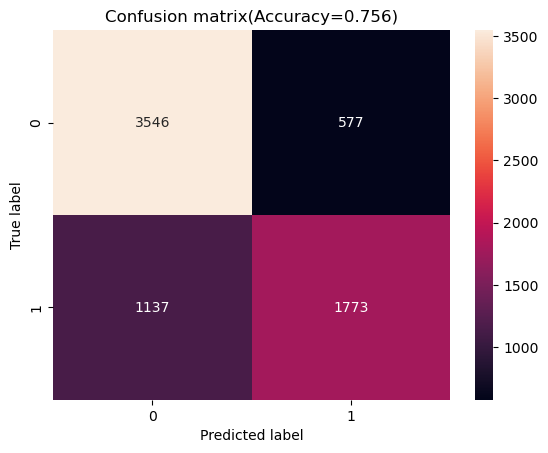

In [7]:
model_basic, X_test, y_test, test_all = basic_xgboost(df_xgboost, seed=7, test_size=0.33)
predictions = model_predictions(model_basic, X_test, y_test)
model_evalutation(predictions)

In [8]:
predictions.head()

,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,Contains_Voting_Language,prop_emigrants_v2p,prop_emigrants_p2v,has_border,comps_without_win,...,RS,AZ,IT,ME,SM,AU,CZ,prob,predictions,actual
10585,True,True,True,2,True,False,-0.399532,-0.866897,False,0.076923,...,0,0,0,0,0,0,0,0.212794,0,0
1958,False,True,False,1,True,False,-0.644757,-0.049910,False,0.692308,...,0,0,0,0,0,0,0,0.140449,0,0
9579,True,False,False,1,False,True,-0.571965,0.229081,False,0.353846,...,0,0,0,0,0,0,0,0.586494,1,1
2178,True,False,False,1,True,False,-0.017305,-1.118413,False,0.707692,...,0,0,0,0,0,0,0,0.493166,0,1
1776,False,True,False,1,True,False,1.287103,-0.190789,False,0.030769,...,0,0,0,0,0,0,0,0.400053,0,0


<AxesSubplot:>

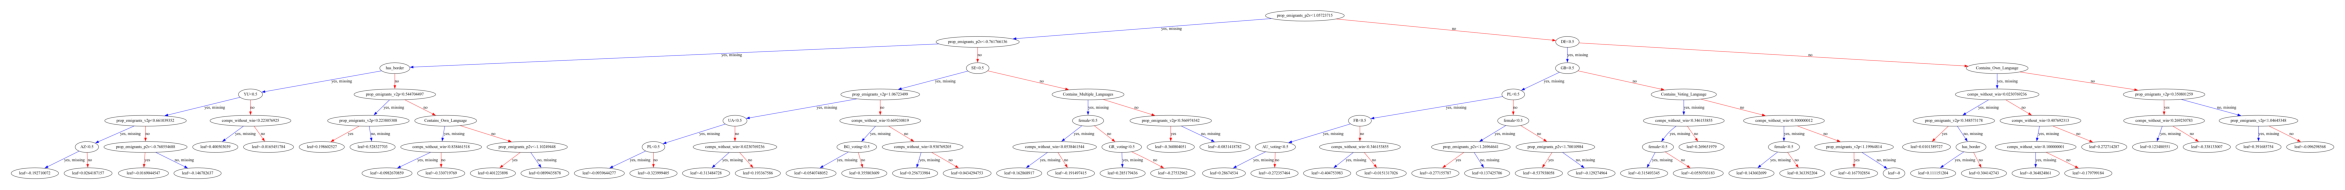

In [9]:
import matplotlib
import xgboost as xgb

graph = xgb.to_graphviz(model_basic, num_trees=1, rankdir='LR')

fig, ax = plt.subplots(figsize=(30, 50))
xgb.plot_tree(model_basic, num_trees=1, ax=ax)

## Ranking Scores

Example: https://medium.com/predictly-on-tech/learning-to-rank-using-xgboost-83de0166229d

In [10]:
test_all.head()

,points,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,Contains_Voting_Language,prop_emigrants_v2p,prop_emigrants_p2v,has_border,...,BY,BG,GE,RS,AZ,IT,ME,SM,AU,CZ
10585,0,True,True,True,2,True,False,-0.399532,-0.866897,False,...,0,0,0,0,0,0,0,0,0,0
1958,0,False,True,False,1,True,False,-0.644757,-0.049910,False,...,0,0,0,0,0,0,0,0,0,0
9579,10,True,False,False,1,False,True,-0.571965,0.229081,False,...,0,0,0,0,0,0,0,0,0,0
2178,8,True,False,False,1,True,False,-0.017305,-1.118413,False,...,0,0,0,0,0,0,0,0,0,0
1776,0,False,True,False,1,True,False,1.287103,-0.190789,False,...,0,0,0,0,0,0,0,0,0,0


In [11]:
import xgboost as xgb
from scipy.stats import rankdata
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import spearmanr
import numpy as np


def xgboost_rank_model(df_input, test_size=0.33, seed=7):

    # subset to the features we want to use
    df2 = df_input[['year', 'from_code2', 'to_code2', 'points',
        'Contains_English', 'Contains_NonEnglish', 
        'Contains_Multiple_Languages',
        'Number_of_Languages', 'Contains_Own_Language', 
        'Contains_Voting_Language', 'gender',
        'prop_emigrants_v2p',  'prop_emigrants_p2v','has_border',
        'comps_without_win']]

    #df2 = df2.loc[df2['Votes'] > 0]

    #df2['has_border'] = df2['has_border'].fillna(0)
    df2 = df2.rename(columns={"points": 'rank'})
    #df2 = df2.rename(columns={"From country": 'id'})


    df2['rank'] = df2['rank'].astype(int) - 1

    df2['id'] = df2['from_code2'].astype(str) + df2['year'].astype(str)

    # remove year column
    df2 = df2[df2.columns.drop('year')]

    # one hot encode the gender, from country and code
    for j in ['gender', 'to_code2', 'from_code2']:
        j_text = "_voting" if j == 'from_code2' else ''
        for i in df2[j].unique():
            df2[i+j_text] = df2[j].apply(lambda x: 1 if x == i else 0)

        df2 = df2[df2.columns.drop(j)]

    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state = seed).split(df2, groups=df2['id'])

    X_train_inds, X_test_inds = next(gss)

    train_data= df2.iloc[X_train_inds]
    X_train = train_data.loc[:, ~train_data.columns.isin(['id','rank'])]
    y_train = train_data.loc[:, train_data.columns.isin(['rank'])]

    groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

    test_data= df2.iloc[X_test_inds]
    test_data = test_data[X_train.columns.tolist() + ['rank', 'id']]


    model = xgb.XGBRanker(  
        tree_method='hist',
        booster='gbtree',
        objective='rank:pairwise',
        random_state=7, 
        learning_rate=0.1,
        colsample_bytree=0.9, 
        eta=0.05, 
        max_depth=6, 
        n_estimators=110, 
        subsample=0.75 
    )

    model.fit(X_train, y_train, group=groups, verbose=True)

    return model, test_data, train_data


def ranked_model_predictions(model, test_set):
    test = test_set.copy()
    
    test['prediction_rel'] = np.nan
    test['predictions'] = np.nan

    for i in test['id'].unique():
        sub_test = test.loc[test['id'] == i, ~test.columns.isin(['id', 'rank', 'prediction_rel', 'predictions'])]

        preds = model.predict(sub_test)

        # get the order of the predictions 
        res = rankdata(preds, method='ordinal')
        test.loc[test['id'] == i, 'prediction_rel'] = res

        # create a score for top 10 predictions getting 1:10 and others 0
        top10 = test.loc[test['id'] == i, 'prediction_rel'].nlargest(10).values

        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'prediction_rel'].apply(lambda x: x if x in top10 else 0)
        
        # if not zero subtract min(top10) 
        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: x - max(top10) + 10 if x != 0 else 0)

        # if 10 set to 12
        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 12 if x == 10 else x)
        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 10 if x == 9 else x)

    test['actual'] = test['rank'] + 1


    accuracy = accuracy_score(test['actual'], test['predictions'])
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    return test

In [12]:
model_ranked_all, test_data_all, train_data_all = xgboost_rank_model(df_xgboost, seed=7, test_size=0.33)
out_all = ranked_model_predictions(model_ranked_all, test_data_all)

Accuracy: 49.34%


In [13]:
# without zeroes
temp = out_all.loc[(out_all['predictions'] != 0) & (out_all['actual'] != 0)]


accuracy = accuracy_score(temp['actual'], temp['predictions'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 14.83%


In [14]:
out_all['predictions'].value_counts()

0.0     4167
10.0     288
7.0      288
4.0      288
1.0      288
5.0      288
8.0      288
3.0      288
12.0     288
2.0      288
6.0      288
Name: predictions, dtype: int64

In [15]:
out_all.head()

,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,Contains_Voting_Language,prop_emigrants_v2p,prop_emigrants_p2v,has_border,comps_without_win,...,RS_voting,AZ_voting,SM_voting,IT_voting,AU_voting,rank,id,prediction_rel,predictions,actual
24,False,True,False,1,True,False,-1.158297,-0.532321,False,0.169231,...,0,0,0,0,0,-1,HR1998,14.0,0.0,0
25,False,True,False,1,True,False,-0.552301,NaN,False,0.646154,...,0,0,0,0,0,3,HR1998,9.0,0.0,4
26,False,True,False,1,True,False,-3.141613,-2.118194,False,0.646154,...,0,0,0,0,0,-1,HR1998,13.0,0.0,0
27,False,True,False,1,True,False,0.580425,1.016399,False,0.646154,...,0,0,0,0,0,5,HR1998,23.0,10.0,6
28,False,True,False,1,True,False,-1.021247,-1.577323,False,0.646154,...,0,0,0,0,0,-1,HR1998,4.0,0.0,0


### Plots

In [16]:
def violins(pred):
    prediction_df = pred.copy()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7)) 

    if(max(prediction_df['actual']) < 12):    
        if(max(prediction_df['actual']) == 11):
            prediction_df['predictions'] = prediction_df['predictions'] + 1
            prediction_df['actual'] = prediction_df['actual'] + 1
        prediction_df['predictions'] = prediction_df['predictions'].apply(lambda x: 12 if x == 10 else x)
        prediction_df['predictions'] = prediction_df['predictions'].apply(lambda x: 10 if x == 9 else x)
        prediction_df['actual'] = prediction_df['actual'].apply(lambda x: 12 if x == 10 else x)
        prediction_df['actual'] = prediction_df['actual'].apply(lambda x: 10 if x == 9 else x)

    # violin plot of predictions for each rank
    sns.violinplot(x="actual", y="predictions", data=prediction_df, order=range(0, 13), ax=ax1)
    sns.violinplot(y="actual", x="predictions", data=prediction_df, order=range(0, 13), ax=ax2)

    # add a best fit line - scale is wrong because numeric on top of categorical
    sns.regplot(x="actual", y="predictions", data=prediction_df, scatter=False, color='black', ax=ax1)
    sns.regplot(y="actual", x="predictions", data=prediction_df, scatter=False, color='black', ax=ax2)


    # spearman correlation
    corr, _ = spearmanr(prediction_df['actual'], prediction_df['predictions'])

    fig.suptitle('Predicted Score vs Actual Score (r = ' + str(round(corr, 4)) + ')', fontsize=15)

    # set x label
    ax1.set_xlabel('Actual Score')
    ax1.set_ylabel('Predicted Score')
    ax2.set_ylabel('Actual Score')
    ax2.set_xlabel('Predicted Score')

def cm_heatmap (prediction_df, title='Confusion matrix', ax=None):
    cm = confusion_matrix(prediction_df['actual'], prediction_df['predictions'])

    plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax, vmin=0, vmax=100)

    if(len(cm[[0]][0]) == 11) : 
    # change the tick labels
        plot.set_xticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
        plot.set_yticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
    else: 
        plot.set_xticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])
        plot.set_yticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])

    plot.set_title(title)
    plot.set_ylabel('Actual Score')
    plot.set_xlabel('Predicted Score')

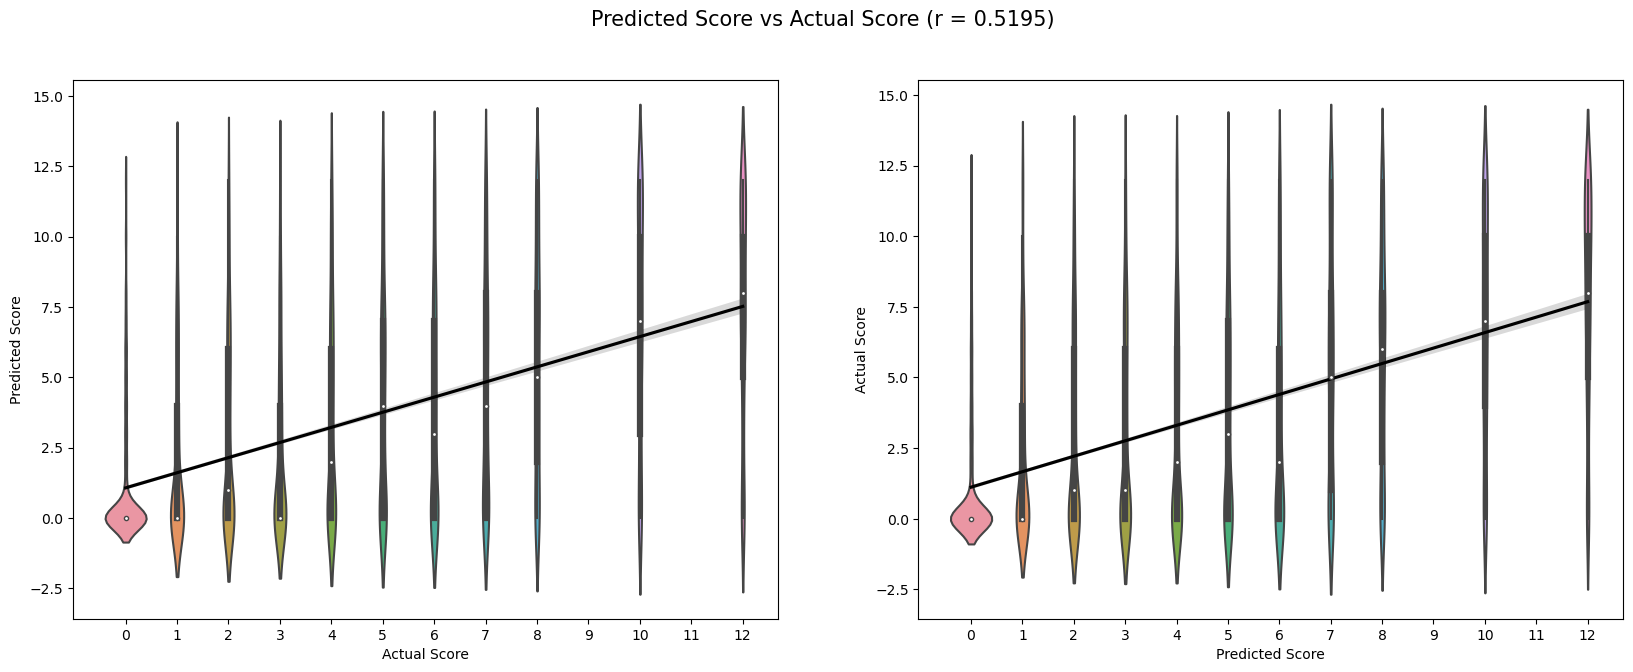

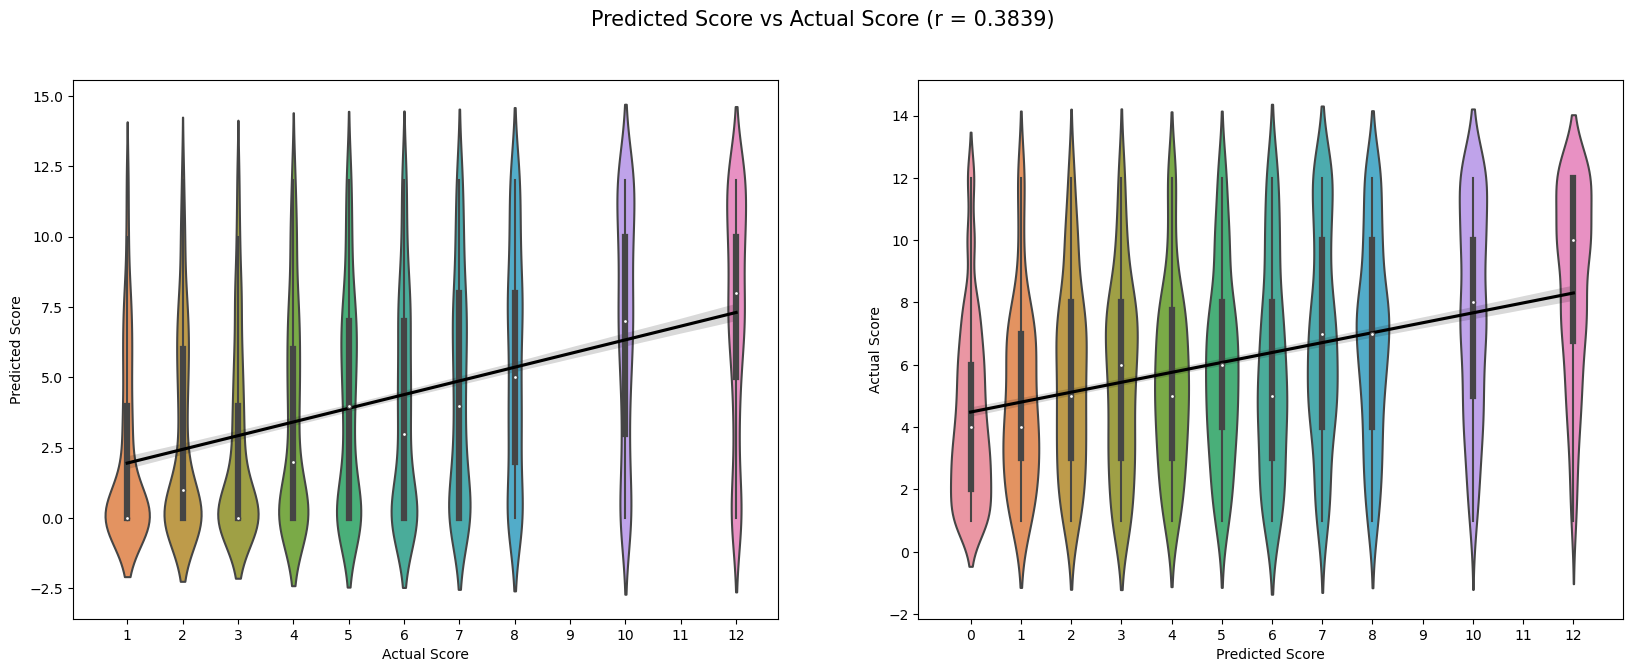

In [17]:
violins(out_all)
violins(out_all.loc[out_all['actual'] > 0])

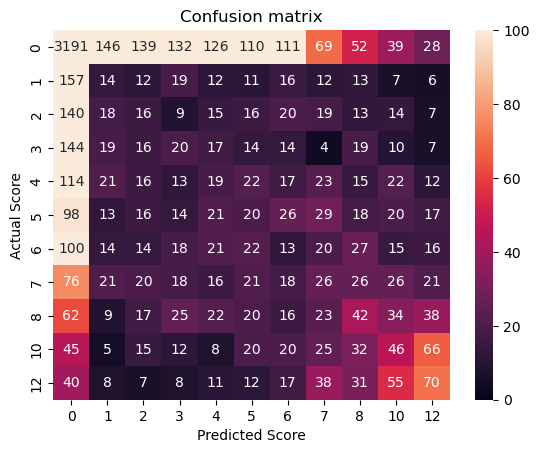

In [18]:
cm_heatmap(out_all)

plt.savefig('../../plots/xgboost_confusion_matrix.pdf', bbox_inches='tight')

See [here](https://discuss.xgboost.ai/t/evaluating-xgboost-ranking/959/2) for description of prediction scores

The 0 predictions are coming up when we have more that 10 non-zeroes (due to draws). So this actually works quite well I think.

### Quickly see how this compares to a non pairwise rank model


/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_83942/1277101257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votes['Votes2'] = df_votes["points"] - 1
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_83942/1277101257.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 8 if x == 9 else x)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_83942/1277101257.py:5: SettingWithCopyWarning: 
A value is trying to be set o

Accuracy: 13.26%


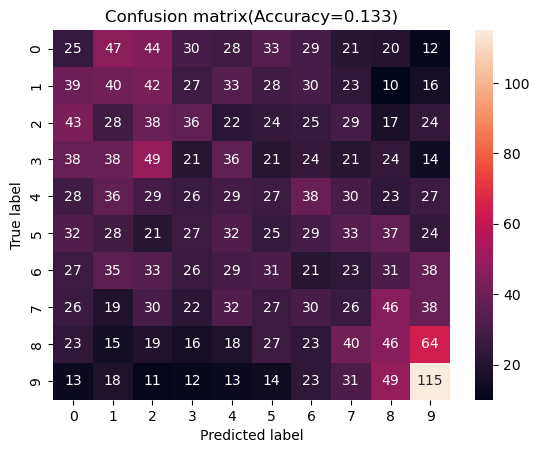

In [19]:
df_votes = df_xgboost.loc[df_xgboost['points'] > 0]

df_votes['Votes2'] = df_votes["points"] - 1
df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 8 if x == 9 else x)
df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 9 if x == 11 else x)

model, X_test, y_test, t2 = basic_xgboost(df_votes, seed=7, test_size=0.33, predictor_column='Votes2')
predictions = model_predictions(model, X_test, y_test)
model_evalutation(predictions)

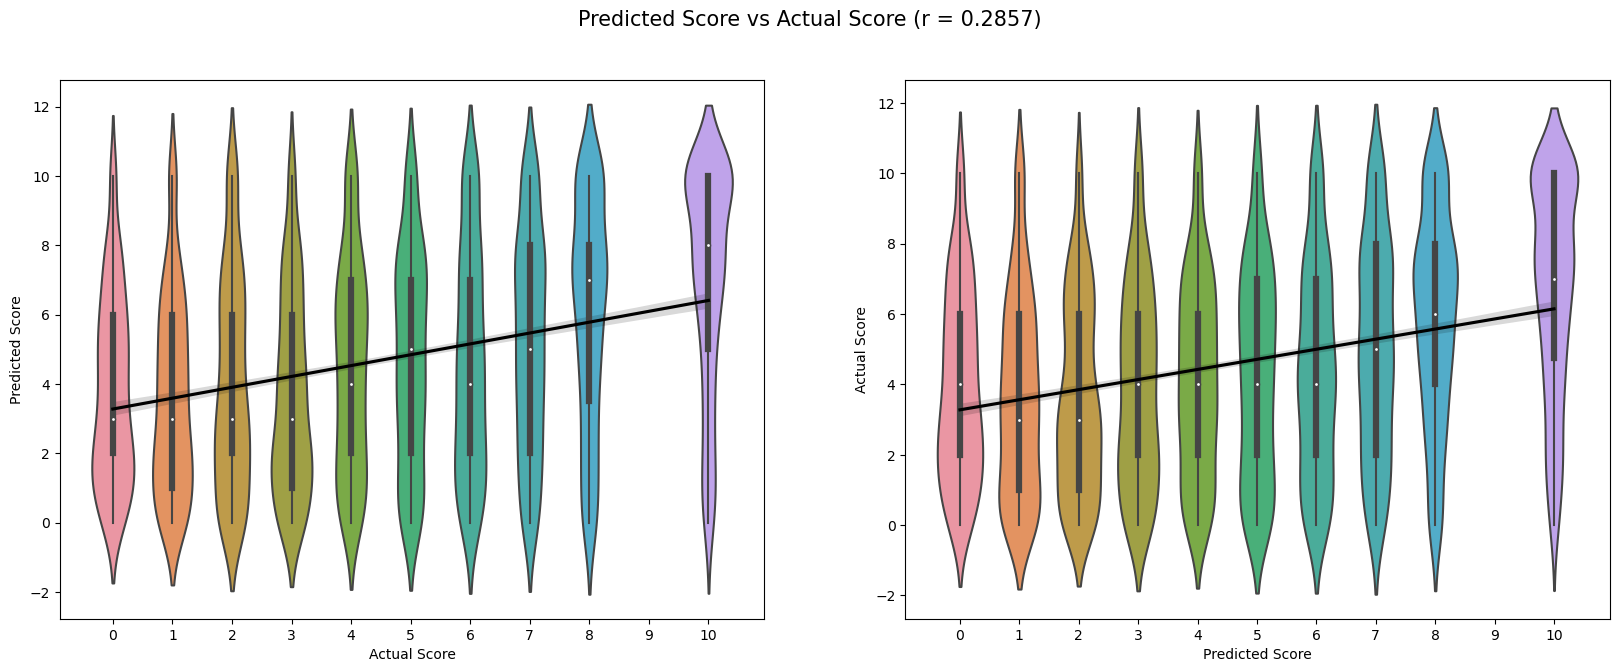

In [20]:
violins(predictions)

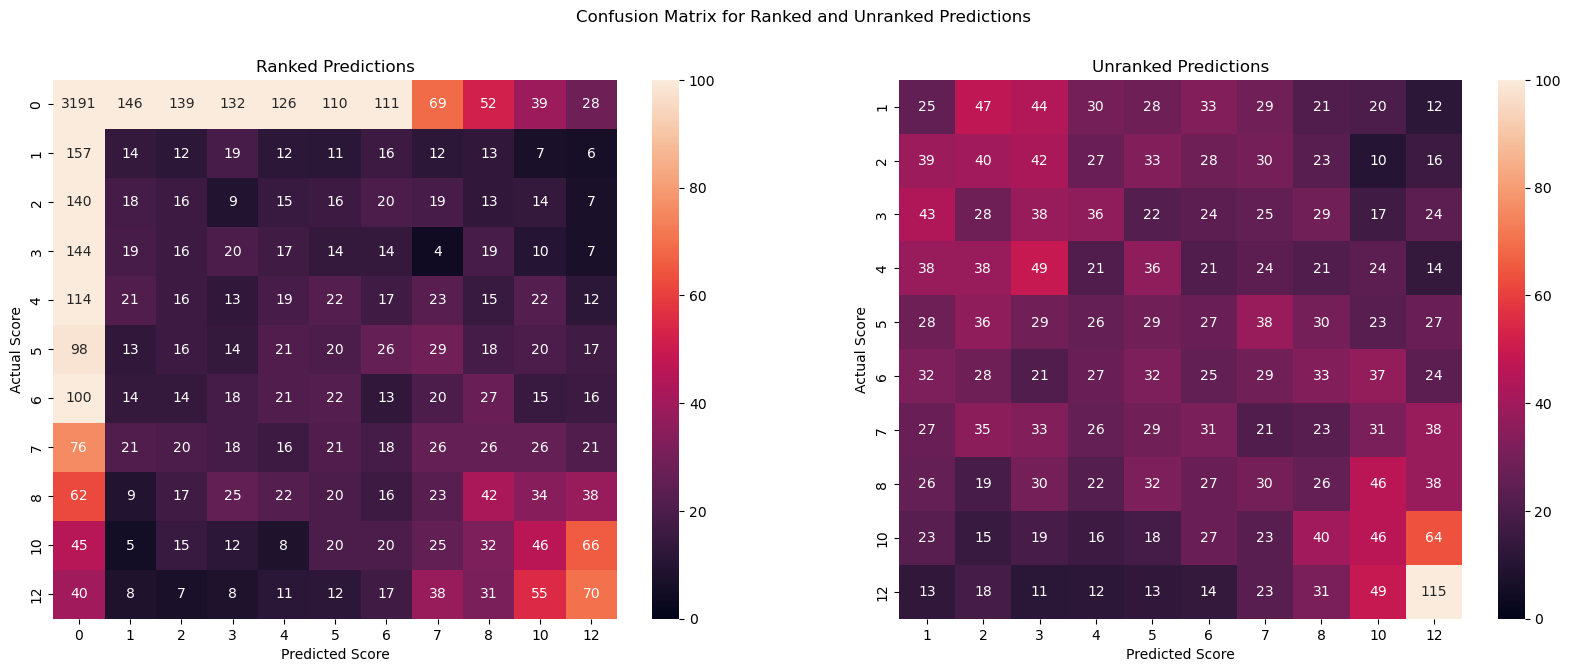

In [21]:
# ranked and unranked plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Confusion Matrix for Ranked and Unranked Predictions')

# ranked plot
cm_heatmap(out_all, title='Ranked Predictions', ax=ax1)
cm_heatmap(predictions, title='Unranked Predictions', ax=ax2)

# Predict the 2023 results

In [22]:
df_xgboost.head()

,year,from_code2,points,to_code2,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,Contains_Voting_Language,gender,prop_emigrants_v2p,prop_emigrants_p2v,has_border,comps_without_win,received_vote
0,1998,BE,5,HR,False,True,False,1,True,False,female,-0.459294,-1.228039,False,0.646154,1
1,1998,BE,2,CY,False,True,False,1,True,False,male,-0.123958,-1.202616,False,0.646154,1
2,1998,BE,0,EE,False,True,False,1,True,False,male,-3.141613,-1.316419,False,0.646154,0
3,1998,BE,0,MK,False,True,False,1,True,False,male,NaN,-1.034414,False,0.646154,0
4,1998,BE,0,FI,False,True,False,1,True,False,group,-0.632590,-0.063750,False,0.646154,0


In [23]:
# read in the csv
df_2023 = pd.read_csv('../../data/df_2023.csv')


df_2023['id'] = df_2023['from_code2'] + df_2023['year'].astype(str)
df_2023['received_vote'] = 0

# drop Votes2 column
#df_xgboost = df_xgboost.drop(['Votes2'], axis=1)

#df_2023 = df_2023[df_xgboost.columns]

In [24]:
df_2023['from_code2'].value_counts().shape

(49,)

In [25]:
# Remove russia from the voting
df_2023 = df_2023.loc[df_2023['from_code2'] != 'RU', ]

In [26]:
df_2023['from_code2']

df_2023['id'] = df_2023['from_code2'] + df_2023['year'].astype(str)

In [27]:
df_2023.columns

Index(['year', 'Artist', 'from_country', 'to_country', 'points',
       'total_points', 'rank', 'from_code2', 'from_code3', 'to_code2',
       'to_code3', 'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language',
       'Contains_Voting_Language', 'gender', 'migration_v2p', 'population_p',
       'prop_emigrants_v2p', 'migration_p2v', 'population_v',
       'prop_emigrants_p2v', 'migration_pop_year', 'comps_without_win',
       'has_border', 'sf', 'id', 'received_vote'],
      dtype='object')

In [ ]:
# set up each semi final
df_2023_sf1 = df_2023.loc[df_2023['semi_final'] == 1, ]


In [ ]:
df_hurdle = df_2023.copy()

# one hot encode the gender, from country and code
for j in ['gender', 'to_code2', 'from_code2']:
    j_text = "_voting" if j == 'from_code2' else ''
    for i in df_hurdle[j].unique():
        df_hurdle[i+j_text] = df_hurdle[j].apply(lambda x: 1 if x == i else 0)

    df_hurdle = df_hurdle[df_hurdle.columns.drop(j)]

#df2= df2[df2.columns.drop('From country')]
df_hurdle= df_hurdle[df_hurdle.columns.drop('year')]

df_hurdle.head()

In [ ]:
# print the test_data_all columns which are not in df_hurdle
print([col for col in df_hurdle.columns if col not in test_data_all.columns])
print([col for col in test_data_all.columns if col not in df_hurdle.columns])

# add the missing columns
for col in test_data_all.columns:
    if col not in df_hurdle.columns:
        df_hurdle[col] = 0

df_hurdle = df_hurdle[test_data_all.columns]

df_hurdle['rank'] = 1

df_hurdle.head()


In [ ]:
#model_ranked_all, test_data_all, train_data_all = xgboost_rank_model(df_2023, seed=7, test_size=0.33)

#sub_test = df_hurdle.loc[df_hurdle['id'] == i, ~df_hurdle.columns.isin(['rank', 'prediction_rel', 'predictions'])]

out_all = ranked_model_predictions(model_ranked_all, df_hurdle)

In [ ]:
out_all['predictions'].value_counts()

In [ ]:
p1 = out_all.copy()


cols = [col for col in p1.columns if '_voting' in col]
cols2 = [col for col in p1.columns if '_voting' not in col]


# wide format _voting columns to long format
p1 = pd.melt(p1, id_vars=cols2, 
                       value_vars= cols, var_name='from_code2')
p1 = p1.loc[p1['value'] == 1]


p1['from_code2'] = p1['from_code2'].str.replace('_voting', '').tolist()

p1 = p1.loc[p1['value'] == 1]
p1 = p1.drop('value', axis=1)



cols2 = [#'year', 
       'from_code2', #'to_code2', 
       #'rank',
       'Contains_English', 'id',
       'has_border', #'value', 
       'prediction_rel',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'Contains_Voting_Language', 
       'prop_emigrants_v2p',  'prop_emigrants_p2v', 'rank',
       'comps_without_win', 'group', 'female', 'male', 
       'predictions', 'actual']

cols = [col for col in p1.columns if col not in cols2]

# # print p1.columns not in cols2
print([col for col in p1.columns if col not in cols2])

p1 = pd.melt(p1, id_vars=cols2, 
                       value_vars= cols, var_name='to_code2')
p1 = p1.loc[p1['value'] == 1]
# # drop value column
p1 = p1.drop('value', axis=1)

p1.head()

In [ ]:
p1['total_points'] = p1.groupby('to_code2')['predictions'].transform('sum')

p1['total_points'].value_counts()

In [ ]:
# results

res = p1[['total_points', 'to_code2']].drop_duplicates()

# match the country name to the country code
res = res.merge(df[['from_code2', 'from_country']], left_on='to_code2', right_on='from_code2', how='left').drop_duplicates()

res['position'] = res['total_points'].rank(ascending=False)

# sort by total_points
res = res.sort_values(by=['total_points'], ascending=False)

# rename from country to country
res = res.rename(columns={'from_country': 'country'})

# remove from_code2 column
res = res.drop('from_code2', axis=1)
res = res.reset_index(drop=True)


In [ ]:
res.loc[res['country'] == 'israel']

In [ ]:
res

In [ ]:
# create a data frame with feature importance and names
df_feature_importance = pd.DataFrame(model_ranked_all.get_booster().get_score(importance_type='weight').items(), 
                                     columns=['feature', 'importance'])

# order the data frame by importance
df_feature_importance = df_feature_importance.sort_values(by=['importance'], ascending=False)

In [ ]:
# create a bar plot
plt.figure(figsize=(7, 5))

# plot the feature importance
sns.barplot(x="importance", y="feature", color='teal',
            data=df_feature_importance.head(10))

# add plot and axes labels
plt.xlabel('F-score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('10 Most Important Features', fontsize=12)

# replace _ with space in y labels
labels = [item.get_text().replace('_', ' ') for item in plt.gca().get_yticklabels()]
labels = [item.title() for item in labels]

plt.gca().set_yticklabels(labels)

plt.show()